# Modeling the number of Bids in eBay coin auctions

a notebook for the book [Bayesian Learning](https://github.com/mattiasvillani/BayesianLearningBook/raw/main/pdf/BayesBook.pdf) by [Mattias Villani](http://mattiasvillani.com) 

### Problem
We want learn about the number of bidders in a eBay internet auction. The dataset below contains information on the number of bidders and covariates/features that can be used to predict the number of bidders. We will later use a Poisson regression to build a prediction model, but we will here only analyze the number of bids using an simple iid Poission model without covariates.

### Import modules and load the data

In [1]:
set.seed(123) # Set the seed for reproducibility
options(repr.plot.width=15, repr.plot.height=6, lwd = 4)
library("RColorBrewer")
colors = brewer.pal(12, "Paired")

# Load the data
eBayData = read.csv('https://github.com/mattiasvillani/BayesianLearningBook/raw/main/data/ebaybids/ebaybids.csv', sep = ',')
nBids = eBayData$nBids

### Data
The dataset contains data from 1000 auctions of collector coins. The dataset was collected and first analyzed in the article [Bayesian Inference in Structural Second-Price Common Value Auctions](https://www.jstor.org/stable/23243804?seq=1). Let's read in the full dataset and extract the variable of interest, the number of bids (nBids):

In [2]:
eBayData = read.csv('https://github.com/mattiasvillani/BayesianLearningBook/raw/main/data/ebaybids/ebaybids.csv', sep = ',')
nBids = eBayData$nBids

### Prior-to-Posterior updating

We will model these data using a **Poisson distribution**: 
$$y_1,...,y_n \vert \theta \overset{iid}{\sim} \mathrm{Poisson}(\theta).$$ 
with a conjugate **Gamma prior**\
$$\theta  \sim \mathrm{Gamma}(\alpha, \beta)$$\
so that the **posterior** is also Gamma:\
$$\theta \vert y_1,\ldots,y_n \sim \mathrm{Gamma}(\alpha + \sum_{i=1}^n y_i, \beta + n)$$

Mean number of counts =  3.635

Prior mean =  4

Posterior mean =  3.635

Prior standard deviation =  2.82842712474619

Posterior standard deviation =  0.0602774064300434

Equal tail 95% prior interval: ( 0.48441855708793 , 11.1432867818778 )

Equal tail 95% posterior interval: ( 3.51799037382847 , 3.75426776553043 )



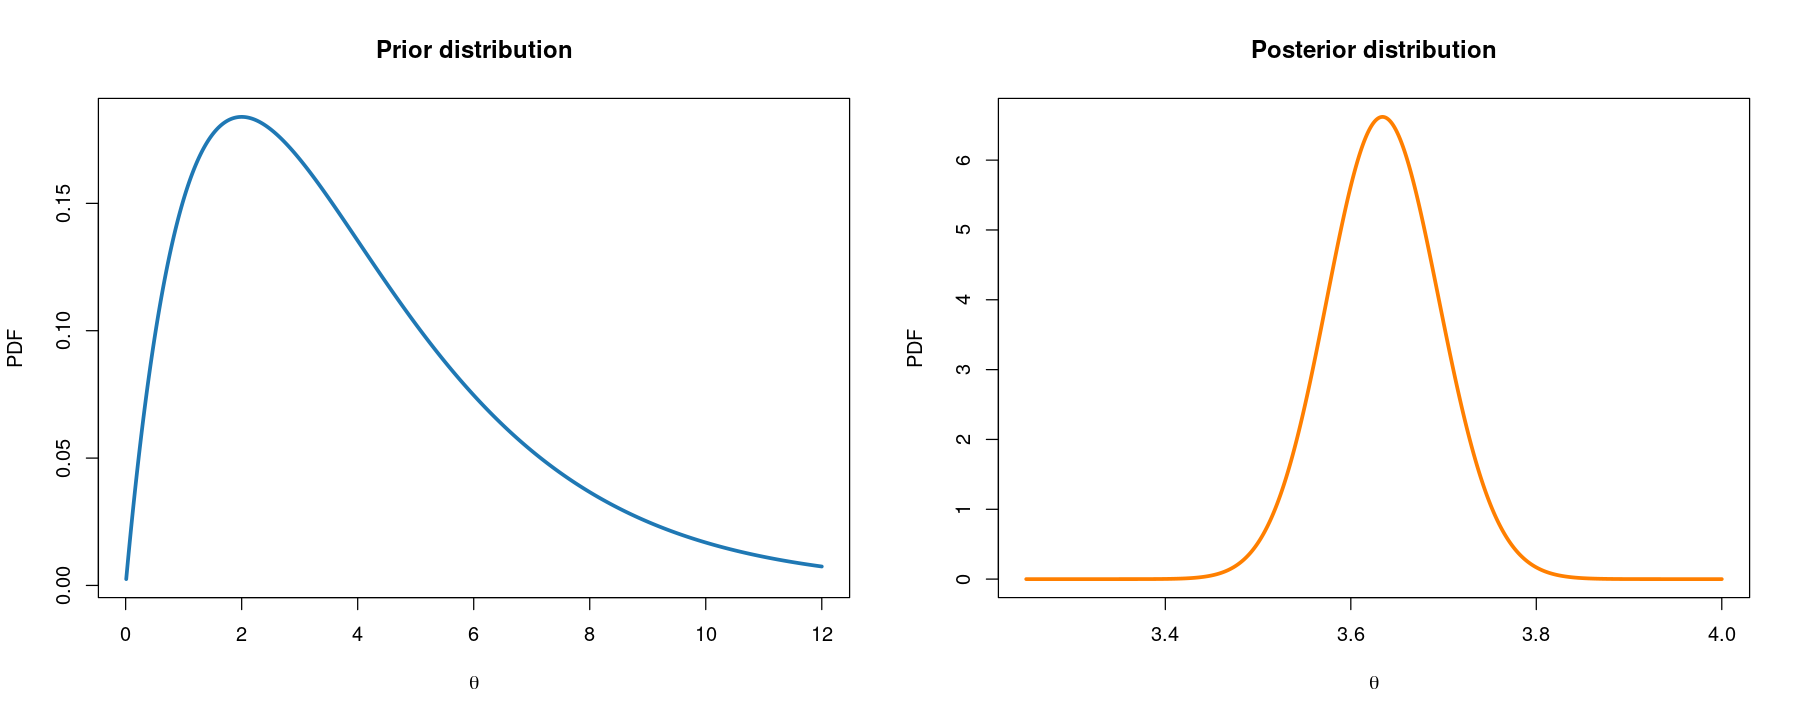

In [3]:
PostPoisson <- function(y, alphaPrior, betaPrior, thetaPriorGrid = NA, thetaPostGrid = NA){

    # Compute Prior density and posterior
    priorDens = dgamma(thetaPriorGrid, shape = alphaPrior, rate = betaPrior)
    n = length(y)
    alphaPost = alphaPrior + sum(y)
    betaPost = betaPrior + n
    postDens = dgamma(thetaPostGrid, shape = alphaPost, rate = betaPost)
    
    message(paste('Mean number of counts = ', mean(y)))
    message(paste('Prior mean = ', alphaPrior/betaPrior))
    message(paste('Posterior mean = ', round(alphaPost/betaPost,3)))
    message(paste('Prior standard deviation = ', sqrt(alphaPrior/(betaPrior**2))))
    message(paste('Posterior standard deviation = ', sqrt( (alphaPrior+sum(y))/((betaPrior+n)**2)) ))
    message(paste('Equal tail 95% prior interval: (' ,qgamma(0.025, shape = alphaPrior, rate = betaPrior),',',qgamma(0.975, shape = alphaPrior, rate = betaPrior),')'))
    message(paste('Equal tail 95% posterior interval: (' ,qgamma(0.025, shape = alphaPost, rate = betaPost),',',qgamma(0.975, shape = alphaPost, rate = betaPost),')'))

    if ( any(is.na(thetaPriorGrid)) != TRUE){
        par(mfrow = c(1,2))
        plot(thetaPriorGrid, priorDens, type = "l", lwd = 3, col = colors[2], xlab = expression(theta), ylab = "PDF", main = 'Prior distribution')
        plot(thetaPostGrid, postDens, type = "l", lwd = 3, col = colors[8], xlab = expression(theta), ylab = "PDF", main = 'Posterior distribution')
    }
}

alphaPrior = 2
betaPrior = 1/2
PostPoisson(y = nBids, alphaPrior = 2, betaPrior = 1/2,
            thetaPriorGrid = seq(0.01, 12, length = 10000), thetaPostGrid = seq(3.25, 4, length = 10000))

### Fit of the Poisson model
Let's plot the data along with the fitted Poisson model. We'll keep things simple and plot the fit for the posterior mean of $\theta$.

In [4]:
plotPoissonFit <- function(y, alphaPrior, betaPrior){
    
    # Compute empirical distribution of the data
    n = length(y)
    yGrid = seq(0, max(y))
    probs = rep(NA,max(y)+1)
    for (i in yGrid){
        probs[i+1] = sum(y == i)/n
    }
    
    # Compute posterior mean and Poisson model fit
    alphaPost = alphaPrior + sum(y)
    betaPost = betaPrior + n
    postMean = alphaPost/betaPost
    
    # Plot the data and model fit
    poisFit = dpois(yGrid, lambda = postMean) 
    plot(yGrid, probs, type = "o", lwd = 6, xlab = "y", ylab = "PMF", col = colors[1], main = 'Fitted Poisson model', 
           ylim = c(0,max(probs, poisFit)))
    lines(yGrid, poisFit, col = colors[2], lwd = 6, type = "o")
    legend(x = "topright", inset=.05, legend = c("Data distribution", "Poisson fit"), pch = c(19,19), cex = c(1,1),
       lty = c(1, 1), pt.lwd = c(3,3), col = c(colors[1], colors[2]))
}

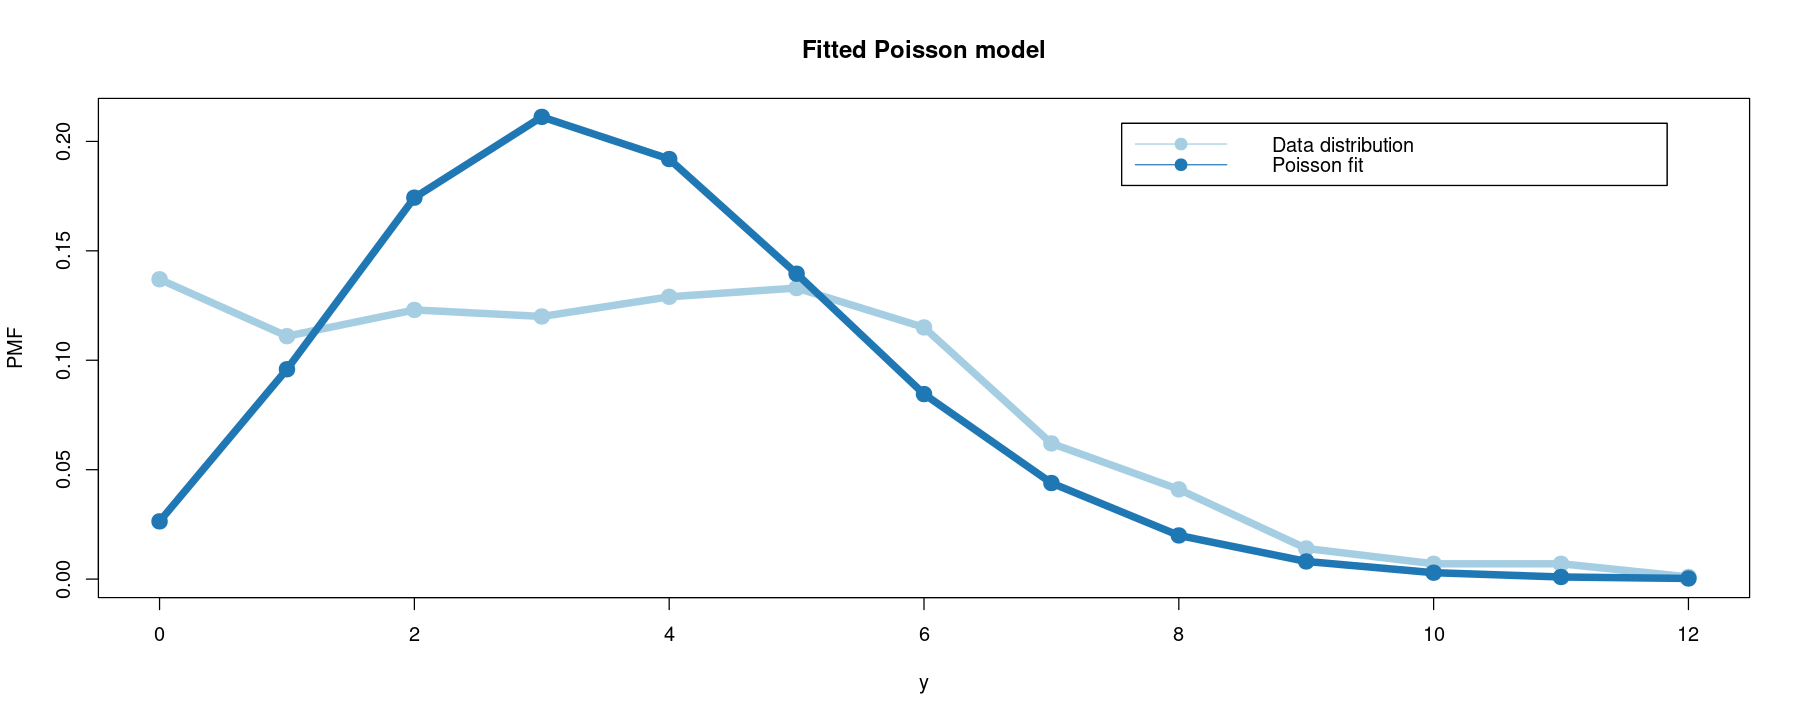

In [5]:
alphaPrior = 2
betaPrior = 1/2
plotPoissonFit(y = nBids, alphaPrior = alphaPrior, betaPrior = betaPrior)

Wow, that's are terrible fit! This data does not look at all like a Poisson distribution. What can we do? 

### Analyzing only the auctions with low reservation prices

We will later model the number of bids using a Poisson *regression* where we take into account several explanatory variables. But, for now, let's split the auctions in two subsets:\
i) auctions with low reservation price in relation to the item's book value (MinBidShare<=0)\
ii) auctions with high reservation price in relation to the item's book value (MinBidShare>0)

Let's start with the 550 auction with low reservation prices. The prior for the auction with low reservation prices is set to $\theta \sim \mathrm{Gamma}(4,1/2)$ to reflect a belief that belief that such auctions are likely to attract more bids.

Mean number of counts =  5.32181818181818

Prior mean =  8

Posterior mean =  5.324

Prior standard deviation =  4

Posterior standard deviation =  0.0983446153216288

Equal tail 95% prior interval: ( 2.17973074725265 , 17.5345461394846 )

Equal tail 95% posterior interval: ( 5.13322503650632 , 5.51871730573948 )



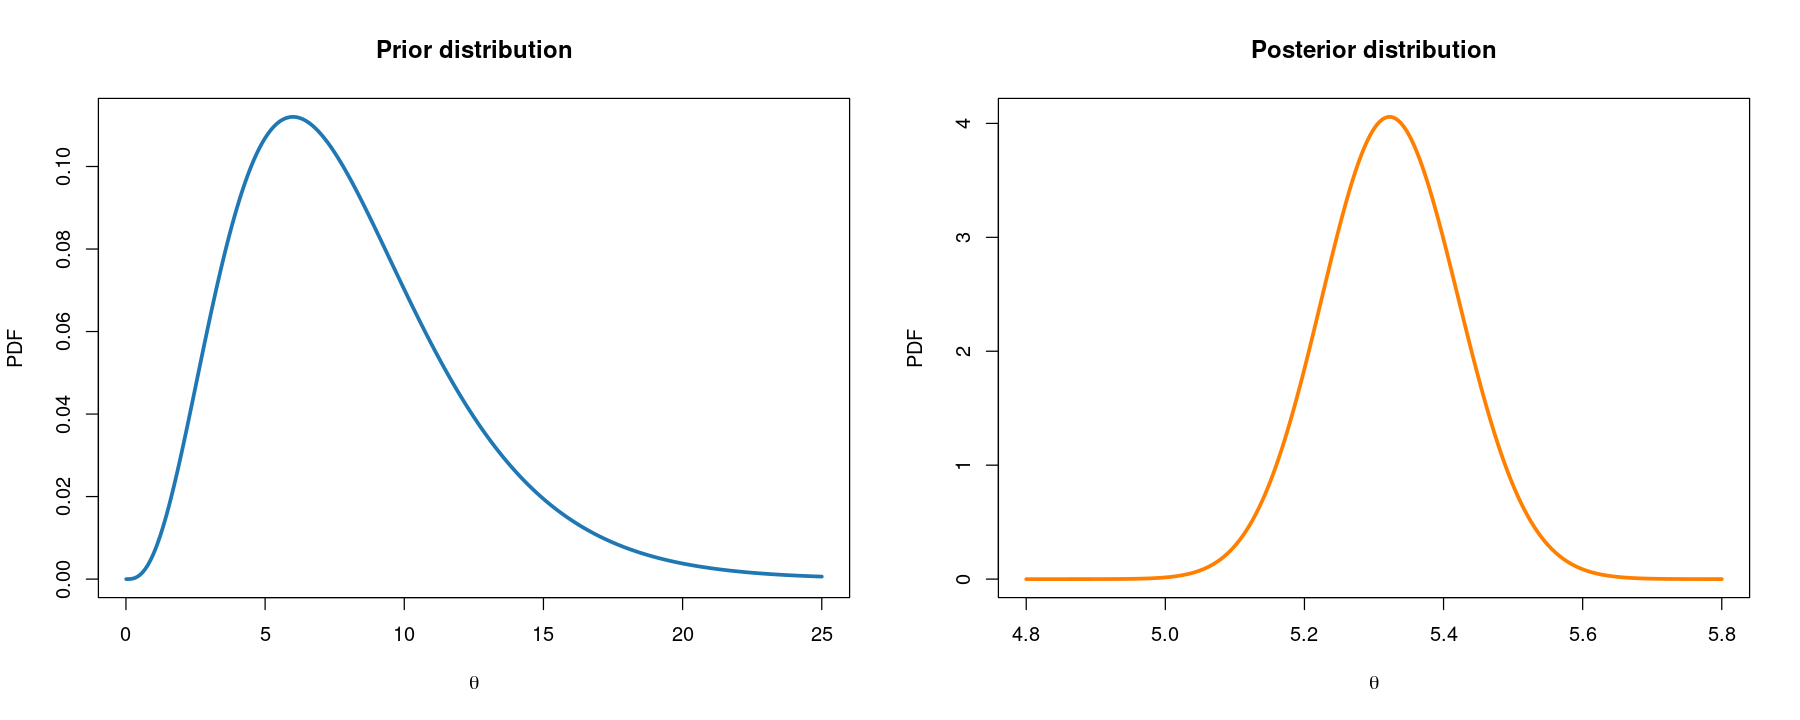

In [6]:
# Auctions with low reservation prices:
nBidsLow = nBids[eBayData$MinBidShare<=0]
PostPoisson(y = nBidsLow, alphaPrior = 4, betaPrior = 1/2,
            thetaPriorGrid = seq(0.01, 25,length = 10000), thetaPostGrid = seq(4.8, 5.8, length = 10000))

As expected, the posterior for the mean number of bids is concentrated on a larger number of bids. People like to bid on items where the seller's reservation price is low.

Is the first for these auctions improved? Yes it is, although there is still room for improvement:

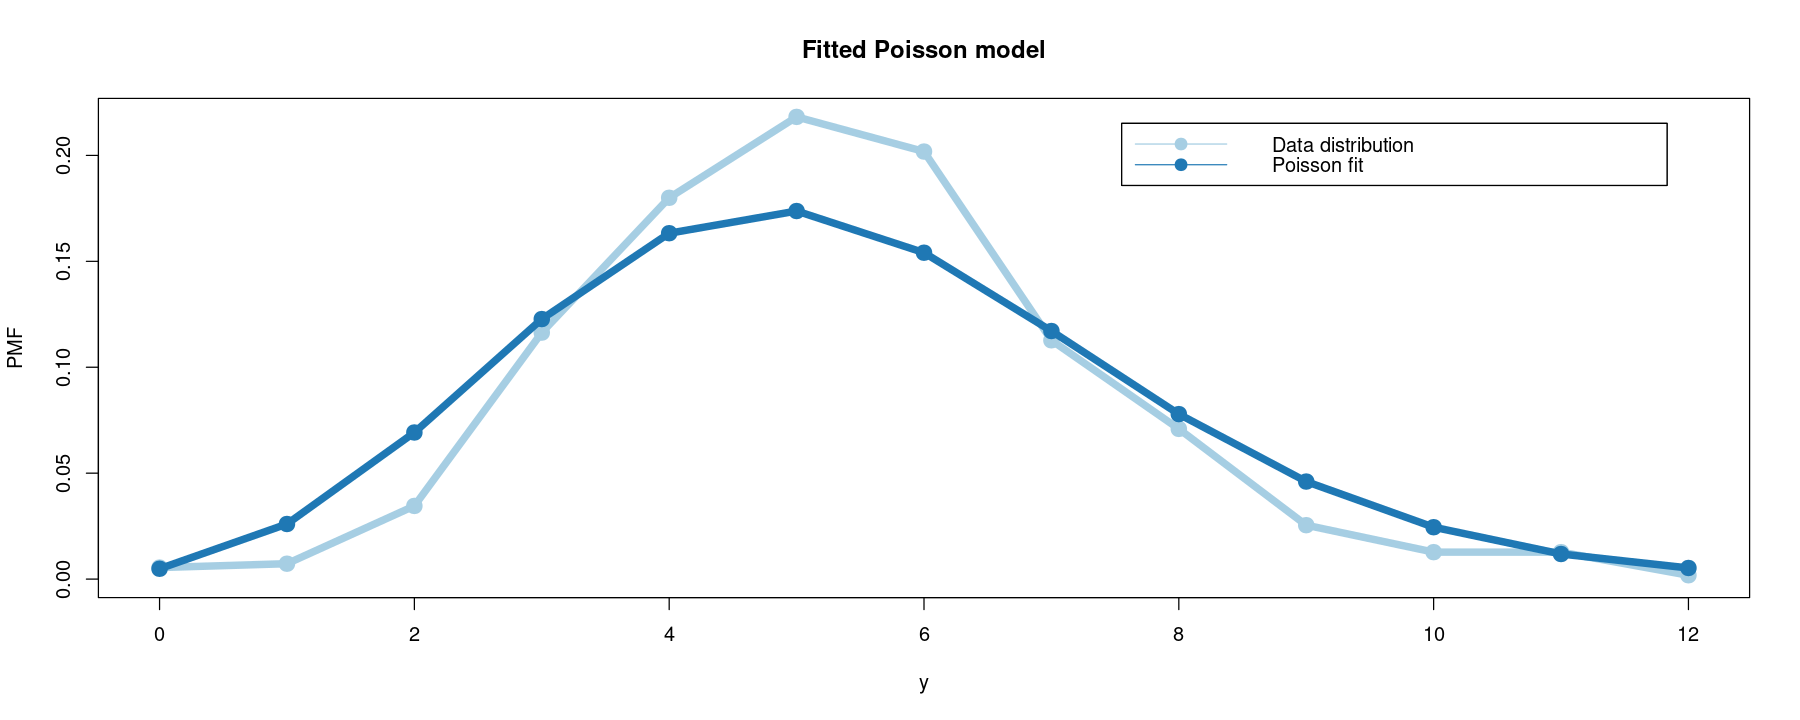

In [7]:
# Plot the fit for low bids
plotPoissonFit(y = nBidsLow, alphaPrior = alphaPrior, betaPrior = betaPrior)

### Analyzing the auctions with high reservation prices

Below are the results for the auction with high reservation bids. The prior is here set to $\theta \sim \mathrm{Gamma}(1,1/2)$ implying less on average. 

Mean number of counts =  1.57333333333333

Prior mean =  2

Posterior mean =  1.574

Prior standard deviation =  2

Posterior standard deviation =  0.059105558071895

Equal tail 95% prior interval: ( 0.0506356159685798 , 7.37775890822787 )

Equal tail 95% posterior interval: ( 1.46007868257167 , 1.69173954979931 )



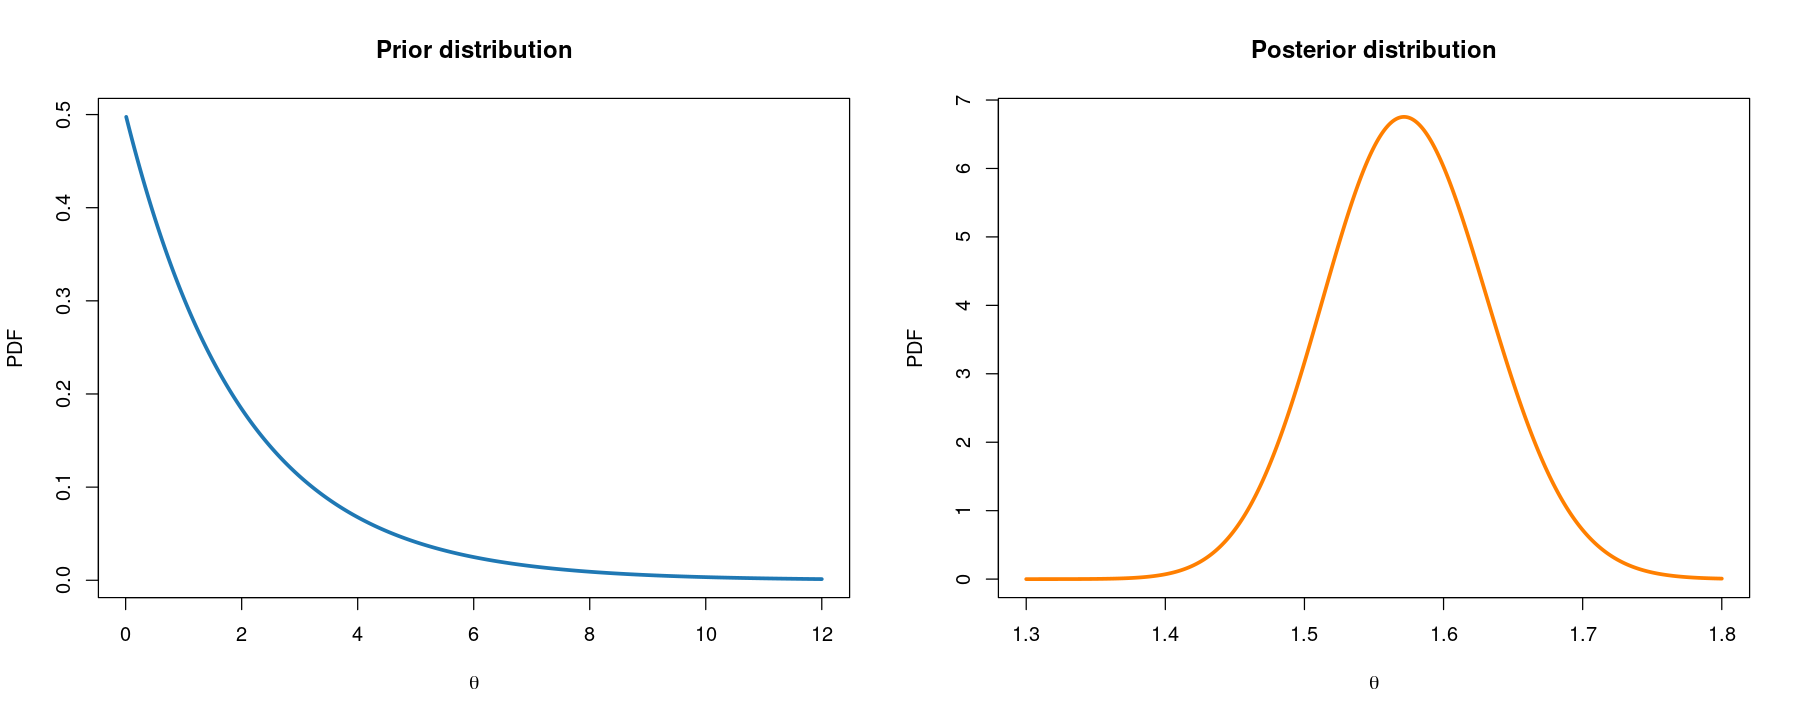

In [8]:
# Auctions with high reservation prices:
nBidsHigh = nBids[eBayData$MinBidShare>0]
PostPoisson(y = nBidsHigh, alphaPrior = 1, betaPrior = 1/2,
            thetaPriorGrid = seq(0.01, 12, length = 10000), thetaPostGrid = seq(1.3, 1.8,length = 10000))

And the fit is not perfect for these bids, but better than before.

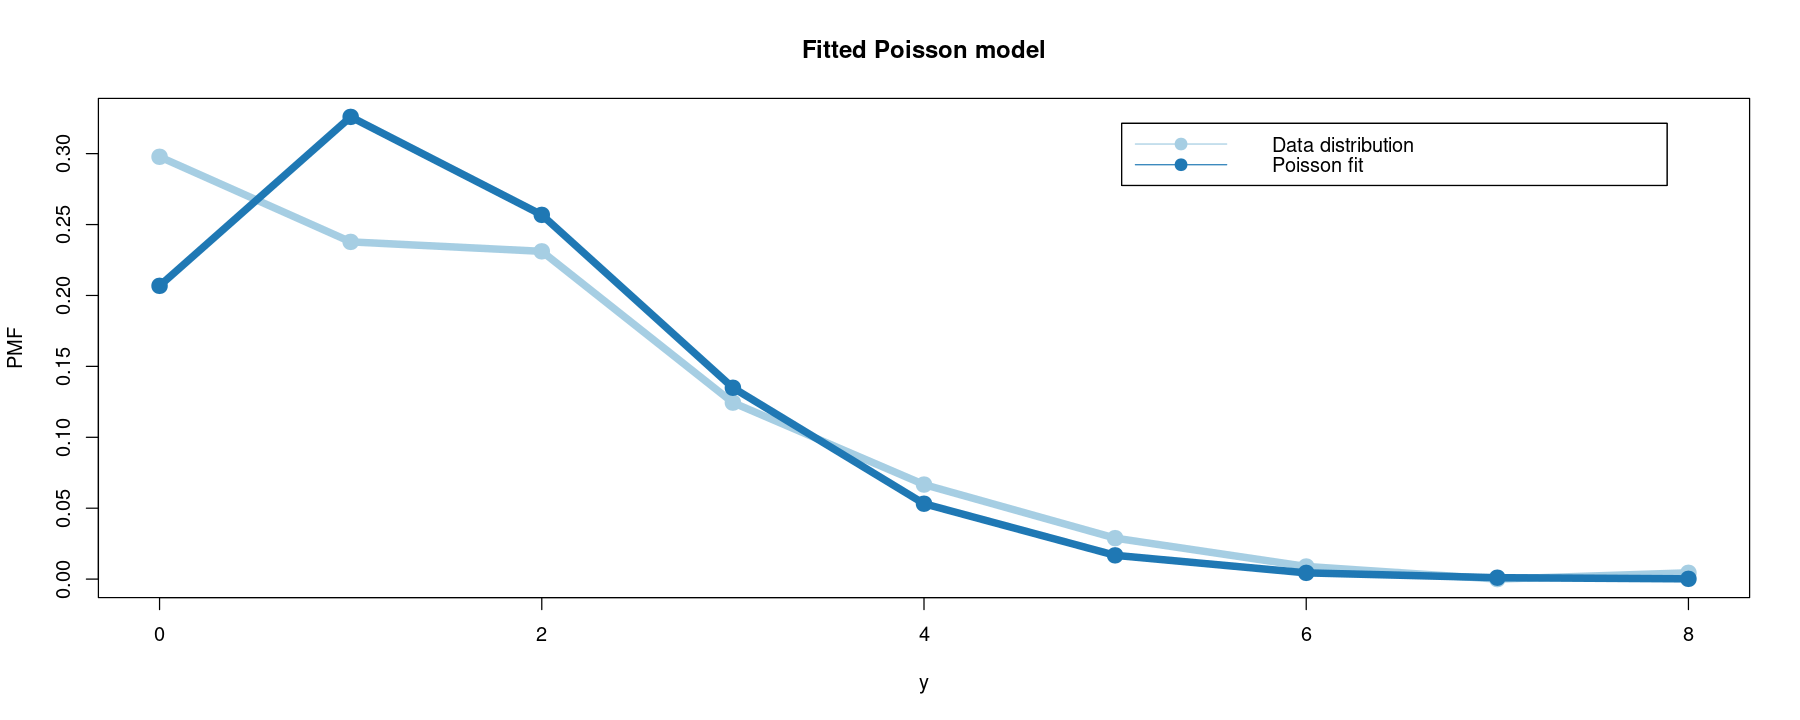

In [9]:
# Plot the fit for high bids
plotPoissonFit(y = nBidsHigh, alphaPrior = alphaPrior, betaPrior = betaPrior)

So, separating the bids into dataset with low and high reservation prices makes the Poisson model a lot better for the data. Later in the book, we will use a Poisson regression with 
reservation price as one of the features, which an even more fine grained analysis. 